In [1]:
import pandas as pd

In [2]:
import scanpy as sc

In [3]:
import altair as alt

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
import itertools

In [7]:
import sccoda.util.cell_composition_data as scc_dat
import sccoda.util.comp_ana as scc_ana
import sccoda.util.data_visualization as scc_viz

2024-11-29 12:43:53.845999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 12:43:53.846075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 12:43:53.847405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 12:43:53.853628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# import scanpy_helpers as sh

In [9]:
import tensorflow as tf

In [10]:
tf.random.set_seed(0)

In [11]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/pseudobulk/"
resDir = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/figures/"
input_path = f"{path}/paired_adata_clean.h5ad"

In [12]:
adata = sc.read_h5ad(input_path)

In [13]:
adata.obs["cell_type_major"].replace("Macrophage alveolar", "Macrophage", inplace=True)

/tmp/ipykernel_2587564/1184347138.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs["cell_type_major"].replace("Macrophage alveolar", "Macrophage", inplace=True)
/tmp/ipykernel_2587564/1184347138.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["cell_type_major"].replace("Macrophage alveolar

In [14]:
adata = adata[
    ~adata.obs["cell_type_major"].isin(["transitional club/AT2", "Ciliated", "other"])
]

In [15]:
adata.obs.cell_type_major.value_counts()

cell_type_major
Macrophage           130447
T cell CD4           118739
T cell CD8            96754
B cell                27723
Tumor cells           25793
T cell regulatory     23411
Neutrophils           15244
DC mature              1158
Name: count, dtype: int64

In [16]:
adata.obs.disease.value_counts()

disease
lung adenocarcinoma              325886
squamous cell lung carcinoma      93286
non-small cell lung carcinoma     20097
Name: count, dtype: int64

In [17]:
# only on primary tumor samples;
# exclude datasets with only a single cell-type
cell_type_column = "cell_type_major"
frac_by_condition = (
    adata.obs.loc[
        lambda x: (x["origin"] == "tumor_primary")
        & ~x["dataset"].isin(["Guo_Zhang_2018"])
        & x["disease"].isin(["lung adenocarcinoma"])
    ]
    .groupby(["dataset", "tumor_stage", "donor_id", "sex"])
    .apply(lambda x: x.value_counts(cell_type_column, normalize=False))
    .reset_index(name="n_cells")
    # .assign(condition=lambda x: x["sex"].astype(str))
)

/tmp/ipykernel_2587564/391052683.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["dataset", "tumor_stage", "donor_id", "sex"])
/tmp/ipykernel_2587564/391052683.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.value_counts(cell_type_column, normalize=False))


In [18]:
frac_pivot = frac_by_condition.pivot(
    index=["donor_id", "dataset", "tumor_stage", "sex"],
    columns=cell_type_column,
    values="n_cells",
).reset_index()

In [19]:
frac_pivot.head()

cell_type_major,donor_id,dataset,tumor_stage,sex,B cell,DC mature,Macrophage,Neutrophils,T cell CD4,T cell CD8,T cell regulatory,Tumor cells
0,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,early,female,8,0,233,0,16,7,2,28
1,Goveia_Carmeliet_2020_patient_46,Goveia_Carmeliet_2020,early,female,6,0,36,0,13,9,0,86
2,Goveia_Carmeliet_2020_patient_50,Goveia_Carmeliet_2020,early,female,5,4,405,0,21,27,3,15
3,He_Fan_2021_P1,He_Fan_2021,early,female,89,22,5571,0,1115,264,99,717
4,He_Fan_2021_P2,He_Fan_2021,early,male,237,62,2601,0,1208,1454,504,554


In [20]:
data_all = scc_dat.from_pandas(
    frac_pivot, covariate_columns=["donor_id", "dataset", "tumor_stage", "sex"]
)

In [21]:
data_all.obs["condition"] = pd.Categorical(
    data_all.obs["sex"], categories=["male", "female"]
)

In [22]:
data_all._sanitize()

/home/kvalem/.conda/envs/test_sccoda/lib/python3.12/site-packages/sccoda/util/data_visualization.py:335: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


<Axes: xlabel='Cell type', ylabel='Proportion'>

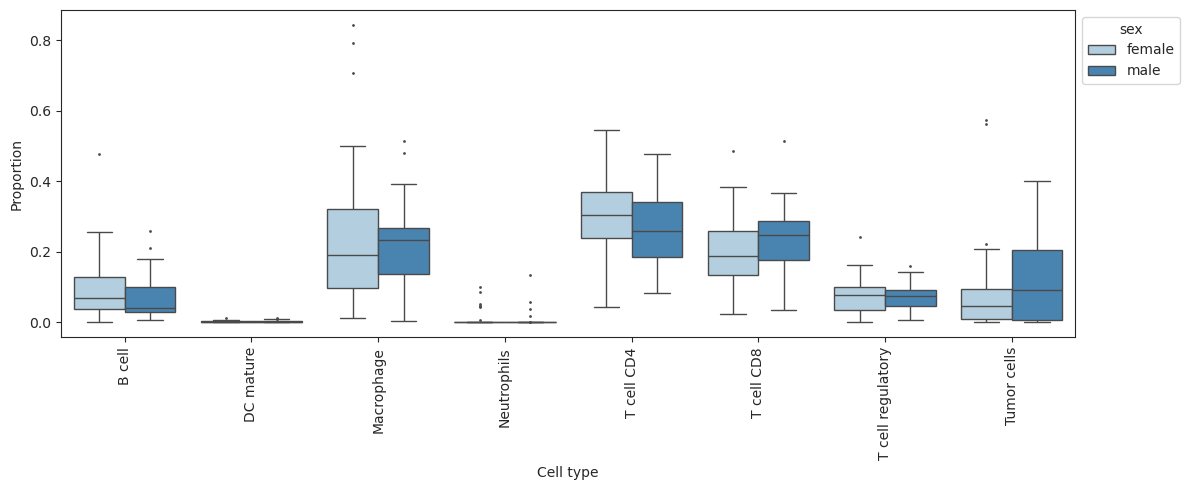

In [23]:
scc_viz.boxplots(data_all, feature_name="sex", figsize=(12, 5))

<Axes: title={'center': 'sex'}, ylabel='Proportion'>

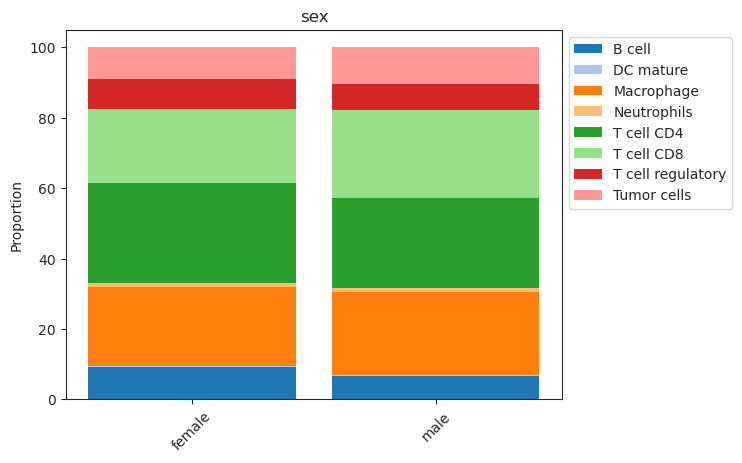

In [24]:
scc_viz.stacked_barplot(data_all, feature_name="sex")

## scCODA

In [25]:
def run_sccoda(sccoda_data, reference_cell_type, n):
    sccoda_mod = scc_ana.CompositionalAnalysis(
        sccoda_data,
        formula=f"sex",
        reference_cell_type=reference_cell_type,
    )
    sccoda_res = sccoda_mod.sample_hmc(num_results=n)
    return sccoda_res

In [26]:
reference_cell_type = "Tumor cells"
mcmc_iterations = 200000

In [27]:
res_tumor_ref2 = run_sccoda(data_all, reference_cell_type, mcmc_iterations)

2024-11-29 12:44:05.721965: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Zero counts encountered in data! Added a pseudocount of 0.5.


  0%|          | 0/200000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1732880648.695923 2587670 service.cc:145] XLA service 0x14c174007680 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732880648.696012 2587670 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-11-29 12:44:08.758342: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732880649.365226 2587670 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 200000/200000 [13:32<00:00, 246.21it/s]


MCMC sampling finished. (835.708 sec)
Acceptance rate: 56.5%


In [28]:
res_tumor_ref2.set_fdr(0.1)

In [29]:
res_tumor_ref2

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [30]:
res_tumor_ref2.effect_df.loc["sex[T.male]"]

,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Cell Type,,,,,,,
B cell,0.0,-0.273,0.219,0.084,0.449451,265.348092,0.0
DC mature,0.0,-0.273,0.272,0.091,0.449944,72.388143,0.0
Macrophage,0.0,-0.181,0.257,0.072,0.416713,569.092235,0.0
Neutrophils,0.0,-0.362,0.220,0.102,0.471328,54.328151,0.0
T cell CD4,0.0,-0.231,0.184,0.068,0.430477,837.182863,0.0
T cell CD8,0.0,-0.085,0.415,0.126,0.553067,616.490258,0.0
T cell regulatory,0.0,-0.184,0.298,0.084,0.450395,281.193353,0.0
Tumor cells,0.0,0.000,0.000,0.000,0.000000,190.765041,0.0


In [31]:
# res_tumor_ref2.to_csv("res_tumor_ref2.csv")

In [32]:
res_tumor_ref2.credible_effects()

Covariate    Cell Type        
sex[T.male]  B cell               False
             DC mature            False
             Macrophage           False
             Neutrophils          False
             T cell CD4           False
             T cell CD8           False
             T cell regulatory    False
             Tumor cells          False
Name: Final Parameter, dtype: bool

In [ ]:
credible_effects_condition = res_tumor_ref2.credible_effects()["dataset[T.UKIM-V-2]"] 
#credible_effects_stage = res_tumor_ref2.credible_effects()["tumor_stage[T.advanced]"]


In [ ]:
res_tumor_ref2.credible_effects()["sex[T.male]"]

In [ ]:
credible_effects_condition

In [ ]:
res_tumor_ref2.effect_df.loc["dataset[T.UKIM-V-2]"]

In [ ]:
(
    alt.Chart(
        res_tumor_ref2.effect_df.loc["sex[T.male]"]
        .reset_index(),
        title="condition",
    )
    .mark_bar()
    .encode(
        x=alt.X("Cell Type", sort="y"),
        y="log2-fold change",
        color=alt.Color("Cell Type"),
    )
  
).resolve_scale(y="shared", color="shared")

# PERTPY

In [ ]:
############################## PERTY 

In [ ]:
!pip install pertpy

In [ ]:
import pertpy as pt

In [ ]:
haber_cells = pt.dt.haber_2017_regions()
haber_cells.obs

In [ ]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    haber_cells,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_label",
    sample_identifier="batch",
    covariate_obs=["condition"],
)
print(sccoda_data)
print(sccoda_data["coda"].X)
print(sccoda_data["coda"].obs)